In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

import os
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ghouls-goblins-and-ghosts-boo/train.csv.zip
/kaggle/input/ghouls-goblins-and-ghosts-boo/test.csv.zip
/kaggle/input/ghouls-goblins-and-ghosts-boo/sample_submission.csv.zip


In [2]:
dtrain = pd.read_csv('../input/ghouls-goblins-and-ghosts-boo/train.csv.zip')
dtest = pd.read_csv('../input/ghouls-goblins-and-ghosts-boo/test.csv.zip')

## Data Preprocessing

In [3]:
dtrain.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [4]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [5]:
dtrain.shape

(371, 7)

In [6]:
dtrain.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


## Exploratory Data Analysis

First, let's check the distribution

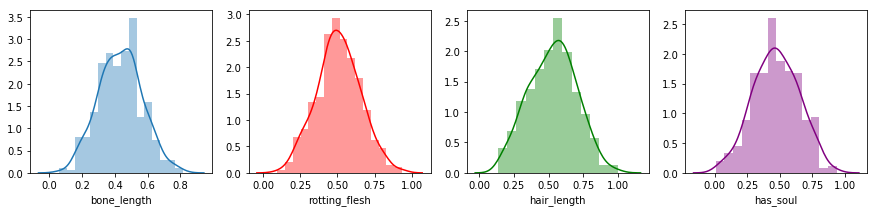

In [7]:
f,ax = plt.subplots(1,4, figsize=(15,3))

sns.distplot(dtrain['bone_length'], ax = ax[0])
sns.distplot(dtrain['rotting_flesh'], ax = ax[1], color = 'r')
sns.distplot(dtrain['hair_length'], ax = ax[2], color = 'g')
sns.distplot(dtrain['has_soul'], ax = ax[3], color = 'purple')

plt.show()

Seems like their distribution is quiet normal. Let see if we use log transformation to our data.

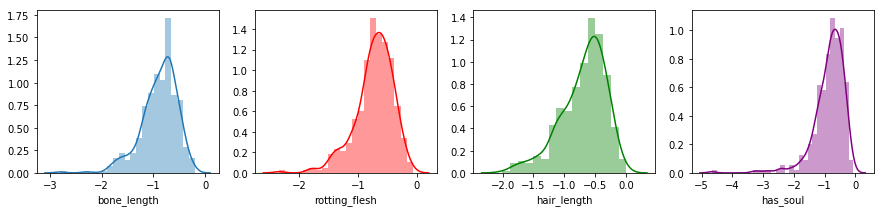

In [8]:
f,ax = plt.subplots(1,4, figsize=(15,3))

sns.distplot(np.log(dtrain['bone_length']), ax = ax[0])
sns.distplot(np.log(dtrain['rotting_flesh']), ax = ax[1], color = 'r')
sns.distplot(np.log(dtrain['hair_length']), ax = ax[2], color = 'g')
sns.distplot(np.log(dtrain['has_soul']), ax = ax[3], color = 'purple')

plt.show()

The distribution has negative skewness then. Now let's plot them with scatter plot.

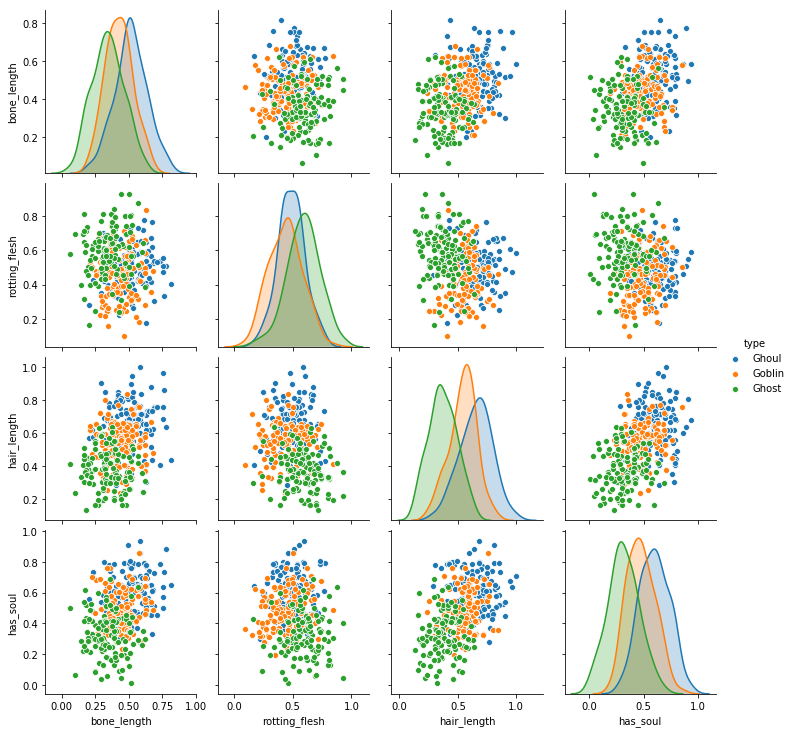

In [9]:
sns.pairplot(data=dtrain.iloc[:,1:], hue = 'type')

What about their correlation?

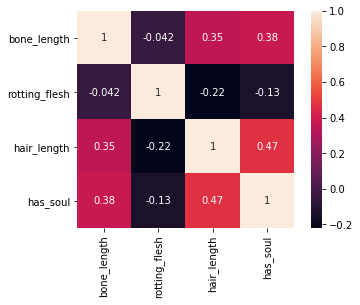

In [10]:
sns.heatmap(dtrain.drop('id', axis = 1).corr(), square = True, annot = True)

From the above, we can get some information:
* `hair_length` and `has_soul` have a good positive correlation
* We also know that `rotting_flesh` has negative correlation with all other features

## Feature Engineering

We do label encoding to make the ML learn easier.

In [11]:
dtrain['type'].unique()

array(['Ghoul', 'Goblin', 'Ghost'], dtype=object)

In [12]:
label_encoder = LabelEncoder()
dtrain['type'] = label_encoder.fit_transform(dtrain['type'])
# 0 : Ghost
# 1 : Ghoul
# 2 : Goblin

In [13]:
dtrain['type'].unique()

array([1, 2, 0])

The `type` feature is in number now. So it's time to encode the `color` feature.

In [14]:
dtrain['color'].unique()

array(['clear', 'green', 'black', 'white', 'blue', 'blood'], dtype=object)

In [15]:
d_color = dtrain['color']

In [16]:
dtrain['clear'] = [1 if d_color[i] == 'clear' else 0 for i in range(len(d_color))]
dtrain['green'] = [1 if d_color[i] == 'green' else 0 for i in range(len(d_color))]
dtrain['black'] = [1 if d_color[i] == 'black' else 0 for i in range(len(d_color))]
dtrain['white'] = [1 if d_color[i] == 'white' else 0 for i in range(len(d_color))]
dtrain['blue'] = [1 if d_color[i] == 'blue' else 0 for i in range(len(d_color))]
dtrain['blood'] = [1 if d_color[i] == 'blood' else 0 for i in range(len(d_color))]

In [17]:
d_color2 = dtest['color']

In [18]:
dtest['clear'] = [1 if d_color2[i] == 'clear' else 0 for i in range(len(d_color2))]
dtest['green'] = [1 if d_color2[i] == 'green' else 0 for i in range(len(d_color2))]
dtest['black'] = [1 if d_color2[i] == 'black' else 0 for i in range(len(d_color2))]
dtest['white'] = [1 if d_color2[i] == 'white' else 0 for i in range(len(d_color2))]
dtest['blue'] = [1 if d_color2[i] == 'blue' else 0 for i in range(len(d_color2))]
dtest['blood'] = [1 if d_color2[i] == 'blood' else 0 for i in range(len(d_color2))]

In [19]:
dtrain.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,clear,green,black,white,blue,blood
0,0,0.354512,0.350839,0.465761,0.781142,clear,1,1,0,0,0,0,0
1,1,0.575560,0.425868,0.531401,0.439899,green,2,0,1,0,0,0,0
2,2,0.467875,0.354330,0.811616,0.791225,black,1,0,0,1,0,0,0
3,4,0.776652,0.508723,0.636766,0.884464,black,1,0,0,1,0,0,0
4,5,0.566117,0.875862,0.418594,0.636438,green,0,0,1,0,0,0,0


In [20]:
dtest.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,clear,green,black,white,blue,blood
0,3,0.471774,0.387937,0.706087,0.698537,black,0,0,1,0,0,0
1,6,0.427332,0.645024,0.565558,0.451462,white,0,0,0,1,0,0
2,9,0.549602,0.491931,0.660387,0.449809,black,0,0,1,0,0,0
3,10,0.638095,0.682867,0.471409,0.356924,white,0,0,0,1,0,0
4,13,0.361762,0.583997,0.377256,0.276364,black,0,0,1,0,0,0


Now it's time to build our model

## Modelling

In [21]:
train = dtrain.copy()
y = train['type']
x = train.drop(['id', 'color','type'], axis = 1)

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.8, random_state = 0) 
fold = KFold(n_splits = 5)

In [24]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

In [25]:
ensembles=[]
ensembles.append(('rfc',RandomForestClassifier(n_estimators=10)))
ensembles.append(('abc',AdaBoostClassifier(n_estimators=10)))
ensembles.append(('bc',BaggingClassifier(n_estimators=10)))
ensembles.append(('etc',ExtraTreesClassifier(n_estimators=10)))

results=[]
names=[]
for name,model in ensembles:
    result = cross_val_score(model,x_train,y_train,cv=fold,scoring='accuracy')
    results.append(result)
    names.append(name)
    msg="%s : %f (%f)"%(name,result.mean(),result.std())
    print(msg)

rfc : 0.638475 (0.041224)
abc : 0.682429 (0.029115)
bc : 0.675537 (0.044270)
etc : 0.699040 (0.069022)


In [26]:
# Random Forest Tuning
n_estimators=[10,20,30,40,50]
max_depth =  [4,6,8,10,12,24]

param_grid=dict(n_estimators=n_estimators, max_depth=max_depth)

model=RandomForestClassifier()

fold=KFold(n_splits=10,random_state=0)

grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy',cv=fold)
grid_result=grid.fit(x_train,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



Best: 0.702069 using {'max_depth': 8, 'n_estimators': 50} 


In [27]:
rf_best_params = grid_result.best_params_

In [28]:
# AdaBoost Tuning
n_estimators=[10,20,30,40,50]
learning_rate =  [1.0, 0.1, 0.05, 0.01, 0.001]
param_grid=dict(n_estimators=n_estimators, learning_rate=learning_rate)


model=AdaBoostClassifier()

grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy',cv=fold)
grid_result=grid.fit(x_train,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.651494 using {'learning_rate': 1.0, 'n_estimators': 10} 


In [29]:
ab_best_params = grid_result.best_params_

In [30]:
# Bagging Tuning
n_estimators=[10,20,30,40,50]
max_features =  [2,4,6,8,10]

param_grid=dict(n_estimators=n_estimators, max_features=max_features)

model=BaggingClassifier()

grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy',cv=fold)
grid_result=grid.fit(x_train,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.702644 using {'max_features': 10, 'n_estimators': 20} 


In [31]:
bc_best_params = grid_result.best_params_

In [32]:
# Extra Trees Tuning
n_estimators=[10,20,30,40,50]
max_depth =  [4,6,8,10,12,24]

param_grid=dict(n_estimators=n_estimators, max_depth=max_depth)

model=ExtraTreesClassifier()

grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy',cv=fold)
grid_result=grid.fit(x_train,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.732414 using {'max_depth': 6, 'n_estimators': 10} 


In [33]:
et_best_params = grid_result.best_params_

based on our tuning, Let's use VotingClassifier.

In [34]:
rf = RandomForestClassifier(**rf_best_params)
et = ExtraTreesClassifier(**et_best_params)
bc = BaggingClassifier(**bc_best_params)
ab = AdaBoostClassifier(rf, **ab_best_params)

vc = VotingClassifier(estimators=[('et', et), ('rf', rf), ('bc', bc), ('ab', ab)], voting='soft')


In [35]:
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_acc = accuracy_score(y_pred, y_test)
print("Accuracy score: ", vc_acc)

Accuracy score:  0.7733333333333333


In [36]:
# It's time to predict the data
y_pred = vc.predict(dtest.drop(['id','color'], axis = 1))
y_pred

array([1, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 1, 1,
       1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 1, 1, 0, 2, 2, 1,
       1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1,
       0, 2, 0, 2, 1, 2, 2, 2, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2,
       2, 1, 2, 2, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1,
       2, 0, 1, 1, 0, 1, 1, 2, 1, 2, 0, 0, 2, 0, 2, 0, 0, 1, 0, 2, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2,
       1, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 1, 2,
       2, 2, 2, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 2, 0, 0, 2, 0, 2,
       2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 1, 1, 1, 1,
       0, 2, 0, 0, 1, 0, 1, 2, 2, 2, 0, 2, 0, 1, 2,

In [37]:
sub = pd.read_csv('../input/ghouls-goblins-and-ghosts-boo/sample_submission.csv.zip')
sub['type'] = y_pred
sub['type'] = sub['type'].map({
    0:'Ghost',
    1:'Ghoul',
    2:'Goblin'
})

In [38]:
sub

,id,type
0,3,Ghoul
1,6,Goblin
2,9,Ghoul
3,10,Ghoul
4,13,Ghost
...,...,...
524,893,Goblin
525,894,Ghost
526,895,Ghoul
527,898,Ghost


In [39]:
# submit
sub.to_csv('submission.csv', index = False)